In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
GAMMA = 0.99
LR_DQN = 0.03
LR_RND = 0.03
EPS = 1e-8
V_MAX = 10
V_MIN = -10
N_ATOMS = 51
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)
EX_COEF = 2.
IN_COEF = 1.

In [3]:
class CategoricalDuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space, n_atoms):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_atoms)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space * n_atoms)
        )

        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.register_buffer(
            'support', torch.arange(V_MIN, V_MAX + DELTA_Z, DELTA_Z))

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1, N_ATOMS)
        adv_out = self.adv(out).reshape(out.shape[0], -1, N_ATOMS)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        out = val_out + adv_out - adv_mean
        out = self.log_softmax(out)
        probs = out.exp()

        return probs


class FeatureNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature

In [4]:
losses = []
f_losses = []


def learn(net, tgt_net, pred_net, rand_net, net_optim, pred_optim, rep_memory):
    global mean
    global std

    net.train()
    tgt_net.train()
    pred_net.train()
    rand_net.train()

    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))

    dataloader = DataLoader(train_data,
                            batch_size=BATCH_SIZE,
                            pin_memory=use_cuda)
    # like a double DQN
    for i, (s, a, r, r_in, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.to(device).long()
        _s_batch = _s.to(device).float()
        _s_norm = normalize_obs(_s.detach().cpu().numpy(), mean, std)
        _s_norm_batch = torch.tensor(_s_norm).to(device).float()
        rewards = EX_COEF * r.detach().cpu().numpy().astype(np.longfloat) + \
            IN_COEF * r_in.detach().cpu().numpy().astype(np.longfloat)
        dones = d.detach().cpu().numpy().astype(np.bool)

        pred_features = pred_net(_s_norm_batch)
        _p_batch = net(_s_batch)
        _weights = _p_batch * net.support
        _q_batch = _weights.sum(dim=2)
        _q_batch_np = _q_batch.detach().cpu().numpy()[0]
        _action_batch_np = np.argmax(_q_batch_np)

        with torch.no_grad():
            rand_features = rand_net(_s_norm_batch)
            tgt_p_batch = tgt_net(_s_batch)
            _p_best = tgt_p_batch[range(BATCH_SIZE), _action_batch_np]
            _p_best_np = _p_best.cpu().numpy()

        proj_p_np = projection(_p_best_np, rewards, dones)
        proj_p = torch.tensor(proj_p_np).to(device).float()

        p_batch = net(s_batch)
        p_acting = p_batch[range(BATCH_SIZE), a_batch.data]

        # loss
        eps = np.finfo(np.float32).eps.item()
        loss = -(proj_p * (p_acting + eps).log()).sum(dim=1).mean()
        losses.append(loss)
        f_loss = (pred_features - rand_features).pow(2).sum(dim=1).mean()
        f_losses.append(f_loss)

        net_optim.zero_grad()
        loss.backward()
        net_optim.step()
        
        pred_optim.zero_grad()
        f_loss.backward()
        pred_optim.step()


def projection(next_p, rewards, dones):
    proj_p = np.zeros((BATCH_SIZE, N_ATOMS), dtype=np.float32)
    for atom in range(N_ATOMS):
        z = np.minimum(V_MAX, np.maximum(
            V_MIN, rewards + (V_MIN + atom * DELTA_Z) * GAMMA))
        b = (z - V_MIN) / DELTA_Z
        l = np.floor(b).astype(np.int64)
        u = np.ceil(b).astype(np.int64)

        eq_mask = u == l
        proj_p[eq_mask, l[eq_mask]] += next_p[eq_mask, atom]
        ne_mask = u != l
        proj_p[ne_mask, l[ne_mask]] += next_p[ne_mask, atom] * (u - b)[ne_mask]
        proj_p[ne_mask, u[ne_mask]] += next_p[ne_mask, atom] * (b - l)[ne_mask]

        if dones.any():
            proj_p[dones] = 0.0
            z = np.minimum(V_MAX, np.maximum(V_MIN, rewards[dones]))
            b = (z - V_MIN) / DELTA_Z
            l = np.floor(b).astype(np.int64)
            u = np.ceil(b).astype(np.int64)

            eq_mask = u == l
            eq_dones = dones.copy()
            eq_dones[dones] = eq_mask
            if eq_dones.any():
                proj_p[eq_dones, l] = 1.0

            ne_mask = u != l
            ne_dones = dones.copy()
            ne_dones[dones] = ne_mask
            if ne_dones.any():
                proj_p[ne_dones, l] = (u - b)[ne_mask]
                proj_p[ne_dones, u] = (b - l)[ne_mask]

    return proj_p


def get_norm_params(obs_memory):
    global obs_space

    obses = [[] for _ in range(obs_space)]
    for obs in obs_memory:
        for j in range(obs_space):
            obses[j].append(obs[j])

    mean = np.zeros(obs_space, np.float32)
    std = np.zeros(obs_space, np.float32)
    for i, obs_ in enumerate(obses):
        mean[i] = np.mean(obs_)
        std[i] = np.std(obs_)
    return mean, std


def normalize_obs(obs, mean, std):
    means = [mean for _ in range(BATCH_SIZE)]
    stds = [std for _ in range(BATCH_SIZE)]
    mean = np.stack(means)
    std = np.stack(stds)
    norm_obs = (obs - mean) / std

    return np.clip(norm_obs, -5, 5)


def calculate_reward_in(pred_net, rand_net, _obs):
    global mean
    global std

    norm_obs = normalize_obs(_obs, mean, std)
    state = torch.tensor([norm_obs]).to(device).float()
    with torch.no_grad():
        pred_obs = pred_net(state)
        rand_obs = rand_net(state)
        reward = (pred_obs - rand_obs).pow(2).sum()
        clipped_reward = torch.clamp(reward, -1, 1)

    return clipped_reward.item()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        probs = target_net(state)
        weights = probs * net.support
        q = weights.sum(dim=2)
        action = torch.argmax(q)

    return action.item()

In [5]:
# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
max_steps = env.spec.max_episode_steps*env.spec.timestep_limit

# hyperparameter
learn_start = env.spec.timestep_limit*5
memory_size = learn_start*20
update_frq = int(env.spec.timestep_limit/10)
epsilon = 1.
eps_min = 0.005
eps_decay = 1. - np.exp(np.log(eps_min)/(max_steps/5))
num_eval = int(env.spec.max_episode_steps/20)

# global values
total_steps = 0
learn_steps = 0
mean = None
std = None
rewards = []
reward_eval = deque(maxlen=num_eval)
is_learned = False
is_solved = False

# make four nerual networks
net = CategoricalDuelingDQN(obs_space, action_space, N_ATOMS).to(device)
target_net = deepcopy(net)
pred_net = FeatureNet(obs_space).to(device)
rand_net = FeatureNet(obs_space).to(device)

# make optimizer
net_optim = torch.optim.Adam(net.parameters(), lr=LR_DQN, eps=EPS)
pred_optim = torch.optim.Adam(pred_net.parameters(), lr=LR_RND, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)
obs_memory = []

cuda: True
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [6]:
env.spec.max_episode_steps

200

In [7]:
env.spec.reward_threshold

-110.0

In [8]:
env.spec.timestep_limit

200

In [9]:
# play
for i in range(1, env.spec.max_episode_steps+1):
    obs = env.reset()
    done = False
    ep_reward = 0
    ep_reward_in = 0.
    while not done:
        env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)
        
        if not is_learned:
            obs_memory.append(obs)
            reward_in = 0.
        else:
            reward_in = calculate_reward_in(pred_net, rand_net, _obs)

        rep_memory.append((obs, action, reward, reward_in, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        ep_reward_in += reward_in
        if is_learned:
            epsilon -= epsilon * eps_decay
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n====================  Start Learning  ====================\n')
                is_learned = True
                mean, std = get_norm_params(obs_memory)
                obs_memory.clear()
                
            learn(net, target_net, pred_net, rand_net,
                  net_optim, pred_optim, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            target_net.load_state_dict(net.state_dict())
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}, reward_in {:.2f}'.format(
            i, total_steps, ep_reward, ep_reward_in))

        if len(reward_eval) >= num_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in   200 steps, reward -200.00, reward_in 0.00
  2 Episode in   400 steps, reward -200.00, reward_in 0.00
  3 Episode in   600 steps, reward -200.00, reward_in 0.00
  4 Episode in   800 steps, reward -200.00, reward_in 0.00

====================  Start Learning  ====================

  5 Episode in  1000 steps, reward -200.00, reward_in 0.00
  6 Episode in  1200 steps, reward -200.00, reward_in 73.27
  7 Episode in  1400 steps, reward -200.00, reward_in 51.01
  8 Episode in  1600 steps, reward -200.00, reward_in 4.85
  9 Episode in  1800 steps, reward -200.00, reward_in 8.33
 10 Episode in  2000 steps, reward -200.00, reward_in 35.76
 11 Episode in  2200 steps, reward -200.00, reward_in 12.76
 12 Episode in  2400 steps, reward -200.00, reward_in 23.00
 13 Episode in  2600 steps, reward -200.00, reward_in 13.80
 14 Episode in  2800 steps, reward -200.00, reward_in 65.34
 15 Episode in  3000 steps, reward -200.00, reward_in 3.88
 16 Episode in  3200 steps, reward -200.00, rew

135 Episode in 26774 steps, reward -200.00, reward_in 171.58
136 Episode in 26974 steps, reward -200.00, reward_in 133.45
137 Episode in 27174 steps, reward -200.00, reward_in 168.63
138 Episode in 27374 steps, reward -200.00, reward_in 164.59
139 Episode in 27489 steps, reward -115.00, reward_in 95.09
140 Episode in 27689 steps, reward -200.00, reward_in 161.15
141 Episode in 27889 steps, reward -200.00, reward_in 162.71
142 Episode in 28089 steps, reward -200.00, reward_in 152.92
143 Episode in 28289 steps, reward -200.00, reward_in 153.46
144 Episode in 28489 steps, reward -200.00, reward_in 168.79
145 Episode in 28689 steps, reward -200.00, reward_in 177.38
146 Episode in 28889 steps, reward -200.00, reward_in 150.09
147 Episode in 29032 steps, reward -143.00, reward_in 120.05
148 Episode in 29232 steps, reward -200.00, reward_in 164.85
149 Episode in 29432 steps, reward -200.00, reward_in 161.16
150 Episode in 29632 steps, reward -200.00, reward_in 163.73
151 Episode in 29832 step

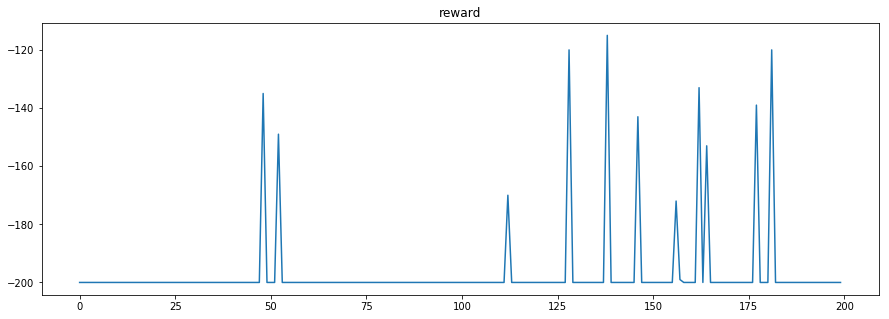

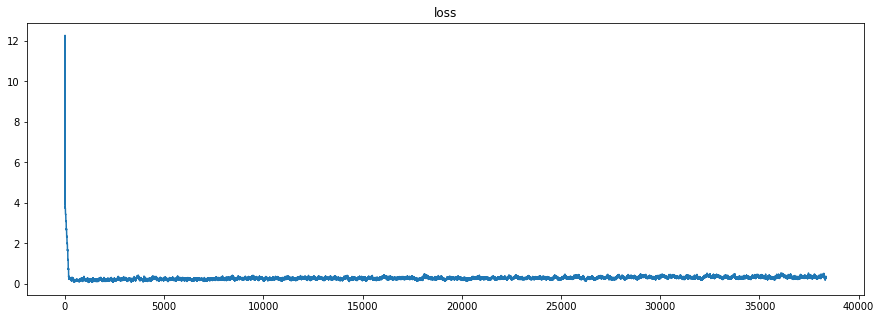

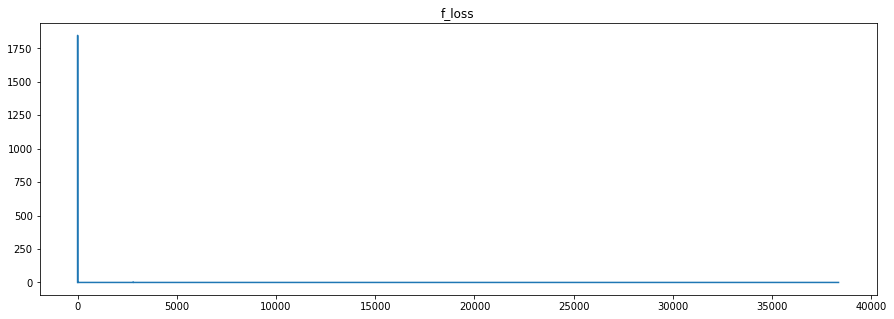

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('f_loss')
plt.plot(f_losses)
plt.show()